<a href="https://colab.research.google.com/github/NishaMDev/ML-Learning/blob/main/Assignment%231/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Created On Tuesday Feb 2 2022**

**@Author : Nisha Devadiga : nishamohan.devadiga@sjsu.edu**

***Problem Statement - With the provided Soccer Dataset, we will group the soccer team based on their gaming styles.***

*In the assignment, we will be using unsupervised learning to identify the groups of soccer team that are similar to each other with respect to their gaming styles.*

#**K - Means Clustering using Scikit and Pytorch library**

***Imports required for the assignment***

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from datetime import datetime


***Data gathering***

In [2]:
from google.colab import drive
#drive.mount('/gdrive')
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
EVENT_FILE_PATH = "/content/drive/My Drive/ML_DataSet/events.csv"
GINFO_FILE_PATH = "/content/drive/My Drive/ML_DataSet/ginf.csv"
DICT_FILE_PATH = "/content/drive/My Drive/ML_DataSet/dictionary.txt"


In [4]:
#EVENT_FILE_PATH = "events.csv"
#GINFO_FILE_PATH = "ginf.csv"
#DICT_FILE_PATH = "dictionary.txt"

# **Data Understanding and Preprocessing**

In [5]:
events = pd.read_csv(EVENT_FILE_PATH,engine="python")

events.head(2) #Printing first 2 rows of the dataset

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0


In [6]:
print('Data has {} rows and {} columns'.format(events.shape[0], events.shape[1]))

Data has 941009 rows and 22 columns


In [7]:
print('Event Data has {} columns with column names as {} '.format(events.shape[1],events.columns.to_list()))

Event Data has 22 columns with column names as ['id_odsp', 'id_event', 'sort_order', 'time', 'text', 'event_type', 'event_type2', 'side', 'event_team', 'opponent', 'player', 'player2', 'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal', 'location', 'bodypart', 'assist_method', 'situation', 'fast_break'] 


***Describing the data***

In [8]:
events.describe().T

,count,mean,std,min,25%,50%,75%,max
sort_order,941009.0,53.858826,32.014268,1.0,27.0,53.0,79.0,180.0
time,941009.0,49.663663,26.488977,0.0,27.0,51.0,73.0,100.0
event_type,941009.0,4.326575,2.995313,1.0,2.0,3.0,8.0,11.0
event_type2,214293.0,12.233764,0.468850,12.0,12.0,12.0,12.0,15.0
side,941009.0,1.481170,0.499646,1.0,1.0,1.0,2.0,2.0
shot_place,227459.0,5.733693,3.326100,1.0,2.0,5.0,9.0,13.0
shot_outcome,228498.0,1.926555,0.797055,1.0,1.0,2.0,3.0,4.0
is_goal,941009.0,0.025978,0.159071,0.0,0.0,0.0,0.0,1.0
location,467067.0,6.209073,5.421736,1.0,2.0,3.0,11.0,19.0
bodypart,229185.0,1.624831,0.740400,1.0,1.0,1.0,2.0,3.0


***Identify the unique values in each feature.***

In [9]:
events.nunique()

id_odsp            9074
id_event         941009
sort_order          180
time                101
text             366076
event_type           11
event_type2           4
side                  2
event_team          142
opponent            142
player             6118
player2            5747
player_in          5093
player_out         4671
shot_place           13
shot_outcome          4
is_goal               2
location             19
bodypart              3
assist_method         5
situation             4
fast_break            2
dtype: int64

***Drop non-important features since our focus is on more on clustering the team based on the similarity between them with respect to gaming style.***

In [10]:
events = events.drop(['id_odsp','id_event','sort_order','time','opponent','player_in','player_out','shot_place','shot_outcome','player','player2','text'], axis=1)

***Identify the feature that has null values but keeping them for further processing.***

In [11]:
events.isnull().sum()

event_type            0
event_type2      726716
side                  0
event_team            0
is_goal               0
location         473942
bodypart         711824
assist_method         0
situation        711872
fast_break            0
dtype: int64

***Now group by Event_team field.***

In [12]:
events.groupby('event_team')
df = events.groupby('event_team',group_keys=False)

In [13]:
df.head()

,event_type,event_type2,side,event_team,is_goal,location,bodypart,assist_method,situation,fast_break
0,1,12.0,2,Hamburg SV,0,9.0,2.0,1,1.0,0
1,2,NaN,1,Borussia Dortmund,0,NaN,NaN,0,NaN,0
2,2,NaN,1,Borussia Dortmund,0,NaN,NaN,0,NaN,0
3,3,NaN,1,Borussia Dortmund,0,NaN,NaN,0,NaN,0
4,8,NaN,2,Hamburg SV,0,2.0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...
852121,8,NaN,2,RB Leipzig,0,2.0,NaN,0,NaN,0
852122,1,12.0,2,RB Leipzig,0,9.0,2.0,1,1.0,0
852123,1,NaN,2,RB Leipzig,0,11.0,1.0,0,1.0,0
852124,1,12.0,2,RB Leipzig,0,15.0,1.0,1,1.0,0


***Get the list of team in the dataset***

In [14]:
teams = events['event_team'].sort_values().unique()
teams

array(['AC Ajaccio', 'AC Milan', 'AJ Auxerre', 'AS Monaco',
       'AS Nancy Lorraine', 'AS Roma', 'Alaves', 'Almeria', 'Angers',
       'Arsenal', 'Aston Villa', 'Atalanta', 'Athletic Bilbao',
       'Atletico Madrid', 'Barcelona', 'Bastia', 'Bayer Leverkusen',
       'Bayern Munich', 'Bologna', 'Bordeaux', 'Borussia Dortmund',
       'Borussia Monchengladbach', 'Bournemouth', 'Brest', 'Burnley',
       'Caen', 'Cagliari', 'Cardiff', 'Carpi', 'Catania', 'Celta Vigo',
       'Cesena', 'Chelsea', 'Chievo Verona', 'Cordoba', 'Crotone',
       'Crystal Palace', 'Deportivo La Coruna', 'Dijon FCO', 'Eibar',
       'Eintracht Frankfurt', 'Elche', 'Empoli', 'Espanyol', 'Everton',
       'Evian Thonon Gaillard', 'FC Augsburg', 'FC Cologne',
       'FC Ingolstadt 04', 'Fiorentina', 'Fortuna Dusseldorf',
       'Frosinone', 'Fulham', 'GFC Ajaccio', 'Genoa', 'Getafe', 'Granada',
       'Guingamp', 'Hamburg SV', 'Hannover 96', 'Hellas Verona',
       'Hertha Berlin', 'Hull', 'Internazionale', 'Juv

***Code to unstack the row into columns***

In [15]:
appended_data = []

for col in events.columns[events.columns != 'event_team']: 
  appended_data.append(df[col].value_counts(dropna=True).sort_index().unstack(col).add_prefix(col+'_'))

data = pd.concat(appended_data, axis=1)  

#data['Event team'] = teams
data.head(5)

,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type2_12.0,event_type2_13.0,event_type2_14.0,event_type2_15.0,side_1,side_2,is_goal_0,is_goal_1,location_1.0,location_2.0,location_3.0,location_4.0,location_5.0,location_6.0,location_7.0,location_8.0,location_9.0,location_10.0,location_11.0,location_12.0,location_13.0,location_14.0,location_15.0,location_16.0,location_17.0,location_18.0,location_19.0,bodypart_1.0,bodypart_2.0,bodypart_3.0,assist_method_0,assist_method_1,assist_method_2,assist_method_3,assist_method_4,situation_1.0,situation_2.0,situation_3.0,situation_4.0,fast_break_0,fast_break_1
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,1106.0,449.0,1593.0,238.0,NaN,12.0,307.0,1534.0,365.0,96.0,15.0,762.0,365.0,17.0,4.0,3093,2622,5601,114,285.0,850.0,336.0,212.0,187.0,9.0,9.0,10.0,71.0,13.0,92.0,12.0,27.0,15.0,457.0,24.0,20.0,3.0,8.0,566,374,166,4953.0,490.0,198.0,43.0,31.0,913,86,74,33,5703.0,12.0
AC Milan,3065.0,1225.0,2677.0,499.0,3.0,18.0,593.0,2840.0,543.0,128.0,42.0,2200.0,543.0,39.0,11.0,6059,5574,11304,329,673.0,1484.0,784.0,344.0,339.0,10.0,28.0,35.0,215.0,34.0,256.0,29.0,93.0,51.0,1465.0,23.0,19.0,1.0,22.0,1936,788,341,9433.0,1556.0,477.0,61.0,106.0,2615,144,219,87,11579.0,54.0
AJ Auxerre,446.0,178.0,558.0,89.0,NaN,3.0,104.0,469.0,94.0,35.0,8.0,302.0,94.0,5.0,NaN,1067,917,1938,46,108.0,237.0,123.0,70.0,54.0,6.0,4.0,4.0,48.0,10.0,33.0,10.0,18.0,1.0,173.0,5.0,8.0,1.0,2.0,199,178,69,1682.0,174.0,92.0,16.0,20.0,364,18,41,23,1967.0,17.0
AS Monaco,1665.0,727.0,1666.0,243.0,NaN,8.0,385.0,1736.0,285.0,106.0,29.0,1219.0,285.0,11.0,7.0,3536,3314,6617,233,407.0,848.0,558.0,221.0,260.0,8.0,19.0,16.0,131.0,32.0,128.0,44.0,56.0,26.0,607.0,11.0,9.0,2.0,18.0,797,574,294,5631.0,754.0,363.0,49.0,53.0,1387,86,142,50,6829.0,21.0
AS Nancy Lorraine,1058.0,356.0,1260.0,160.0,NaN,7.0,232.0,1174.0,254.0,67.0,12.0,791.0,254.0,8.0,1.0,2330,2250,4492,88,239.0,618.0,261.0,172.0,145.0,7.0,11.0,4.0,85.0,15.0,82.0,14.0,28.0,10.0,502.0,17.0,16.0,2.0,4.0,651,239,168,3789.0,523.0,193.0,42.0,33.0,874,69,86,29,4562.0,18.0


***Read the Game info dataset***

In [16]:
info = pd.read_csv(GINFO_FILE_PATH)

info.head(10)

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN
5,lOpzwMkp/,/soccer/germany/bundesliga-2011-2012/hertha-be...,True,2011-08-06,D1,2012,germany,Hertha Berlin,Nurnberg,0,1,2.06,3.75,3.95,NaN,NaN,NaN,NaN
6,M7PhlM2C/,/soccer/france/ligue-1-2011-2012/brest-evian-t...,True,2011-08-06,F1,2012,france,Brest,Evian Thonon Gaillard,2,2,2.29,3.25,3.85,NaN,NaN,NaN,NaN
7,QuWqjrYa/,/soccer/france/ligue-1-2011-2012/ac-ajaccio-to...,True,2011-08-06,F1,2012,france,AC Ajaccio,Toulouse,0,2,2.80,3.10,3.05,NaN,NaN,NaN,NaN
8,UBZQ4smg/,/soccer/france/ligue-1-2011-2012/nice-lyon-UBZ...,True,2011-08-06,F1,2012,france,Nice,Lyon,1,3,4.50,3.55,2.00,NaN,NaN,NaN,NaN
9,Wn69eU5B/,/soccer/germany/bundesliga-2011-2012/koln-wolf...,True,2011-08-06,D1,2012,germany,FC Cologne,VfL Wolfsburg,0,3,3.00,3.80,2.54,NaN,NaN,NaN,NaN


***Describing the data***

In [17]:
info.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10112.0,2014.290249,1.610074,2012.00,2013.00,2014.00,2016.00,2017.00
fthg,10112.0,1.548062,1.309591,0.00,1.00,1.00,2.00,10.00
ftag,10112.0,1.154964,1.142596,0.00,0.00,1.00,2.00,9.00
odd_h,10112.0,2.930120,2.370135,1.06,1.76,2.27,3.08,46.00
odd_d,10112.0,4.278434,1.863643,1.91,3.43,3.68,4.30,35.00
odd_a,10112.0,5.537545,5.700485,1.11,2.74,3.86,6.00,81.00
odd_over,977.0,2.046817,0.367062,1.14,1.79,2.03,2.28,3.40
odd_under,977.0,2.105629,0.536646,1.42,1.78,1.97,2.27,7.50
odd_bts,977.0,1.942917,0.211102,1.41,1.80,1.92,2.05,3.25
odd_bts_n,977.0,2.063941,0.251276,1.44,1.87,2.05,2.20,3.46


In [18]:
print('Data has {} rows and {} columns'.format(info.shape[0], info.shape[1]))

Data has 10112 rows and 18 columns


In [19]:
print('Event Data has {} columns with column names as {} '.format(info.shape[1],info.columns.to_list()))

Event Data has 18 columns with column names as ['id_odsp', 'link_odsp', 'adv_stats', 'date', 'league', 'season', 'country', 'ht', 'at', 'fthg', 'ftag', 'odd_h', 'odd_d', 'odd_a', 'odd_over', 'odd_under', 'odd_bts', 'odd_bts_n'] 


***Count games for each team (home and away) and normalize all features by the number of games.Merge event and game info datasets into one "data" dataset***

In [20]:
game = info['ht'].value_counts() + info['at'].value_counts()
data['game'] = game
data.head()

,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type2_12.0,event_type2_13.0,event_type2_14.0,event_type2_15.0,side_1,side_2,is_goal_0,is_goal_1,location_1.0,location_2.0,location_3.0,location_4.0,location_5.0,location_6.0,location_7.0,location_8.0,location_9.0,location_10.0,location_11.0,location_12.0,location_13.0,location_14.0,location_15.0,location_16.0,location_17.0,location_18.0,location_19.0,bodypart_1.0,bodypart_2.0,bodypart_3.0,assist_method_0,assist_method_1,assist_method_2,assist_method_3,assist_method_4,situation_1.0,situation_2.0,situation_3.0,situation_4.0,fast_break_0,fast_break_1,game
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,1106.0,449.0,1593.0,238.0,NaN,12.0,307.0,1534.0,365.0,96.0,15.0,762.0,365.0,17.0,4.0,3093,2622,5601,114,285.0,850.0,336.0,212.0,187.0,9.0,9.0,10.0,71.0,13.0,92.0,12.0,27.0,15.0,457.0,24.0,20.0,3.0,8.0,566,374,166,4953.0,490.0,198.0,43.0,31.0,913,86,74,33,5703.0,12.0,114.0
AC Milan,3065.0,1225.0,2677.0,499.0,3.0,18.0,593.0,2840.0,543.0,128.0,42.0,2200.0,543.0,39.0,11.0,6059,5574,11304,329,673.0,1484.0,784.0,344.0,339.0,10.0,28.0,35.0,215.0,34.0,256.0,29.0,93.0,51.0,1465.0,23.0,19.0,1.0,22.0,1936,788,341,9433.0,1556.0,477.0,61.0,106.0,2615,144,219,87,11579.0,54.0,210.0
AJ Auxerre,446.0,178.0,558.0,89.0,NaN,3.0,104.0,469.0,94.0,35.0,8.0,302.0,94.0,5.0,NaN,1067,917,1938,46,108.0,237.0,123.0,70.0,54.0,6.0,4.0,4.0,48.0,10.0,33.0,10.0,18.0,1.0,173.0,5.0,8.0,1.0,2.0,199,178,69,1682.0,174.0,92.0,16.0,20.0,364,18,41,23,1967.0,17.0,38.0
AS Monaco,1665.0,727.0,1666.0,243.0,NaN,8.0,385.0,1736.0,285.0,106.0,29.0,1219.0,285.0,11.0,7.0,3536,3314,6617,233,407.0,848.0,558.0,221.0,260.0,8.0,19.0,16.0,131.0,32.0,128.0,44.0,56.0,26.0,607.0,11.0,9.0,2.0,18.0,797,574,294,5631.0,754.0,363.0,49.0,53.0,1387,86,142,50,6829.0,21.0,135.0
AS Nancy Lorraine,1058.0,356.0,1260.0,160.0,NaN,7.0,232.0,1174.0,254.0,67.0,12.0,791.0,254.0,8.0,1.0,2330,2250,4492,88,239.0,618.0,261.0,172.0,145.0,7.0,11.0,4.0,85.0,15.0,82.0,14.0,28.0,10.0,502.0,17.0,16.0,2.0,4.0,651,239,168,3789.0,523.0,193.0,42.0,33.0,874,69,86,29,4562.0,18.0,96.0


***As different teams can have a different number of games, we will count games for each team (home and away) and normalize all features by the number of games.***

In [21]:
for i in data.columns: 
    if (type(data[i][0]) == np.float64) | (type(data[i][0]) == np.int64):
        data[i] = data[i].div(game, axis=0)

In [22]:
data.head()

,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type2_12.0,event_type2_13.0,event_type2_14.0,event_type2_15.0,side_1,side_2,is_goal_0,is_goal_1,location_1.0,location_2.0,location_3.0,location_4.0,location_5.0,location_6.0,location_7.0,location_8.0,location_9.0,location_10.0,location_11.0,location_12.0,location_13.0,location_14.0,location_15.0,location_16.0,location_17.0,location_18.0,location_19.0,bodypart_1.0,bodypart_2.0,bodypart_3.0,assist_method_0,assist_method_1,assist_method_2,assist_method_3,assist_method_4,situation_1.0,situation_2.0,situation_3.0,situation_4.0,fast_break_0,fast_break_1,game
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,9.701754,3.938596,13.973684,2.087719,NaN,0.105263,2.692982,13.456140,3.201754,0.842105,0.131579,6.684211,3.201754,0.149123,0.035088,27.131579,23.000000,49.131579,1.000000,2.500000,7.456140,2.947368,1.859649,1.640351,0.078947,0.078947,0.087719,0.622807,0.114035,0.807018,0.105263,0.236842,0.131579,4.008772,0.210526,0.175439,0.026316,0.070175,4.964912,3.280702,1.456140,43.447368,4.298246,1.736842,0.377193,0.271930,8.008772,0.754386,0.649123,0.289474,50.026316,0.105263,1.0
AC Milan,14.595238,5.833333,12.747619,2.376190,0.014286,0.085714,2.823810,13.523810,2.585714,0.609524,0.200000,10.476190,2.585714,0.185714,0.052381,28.852381,26.542857,53.828571,1.566667,3.204762,7.066667,3.733333,1.638095,1.614286,0.047619,0.133333,0.166667,1.023810,0.161905,1.219048,0.138095,0.442857,0.242857,6.976190,0.109524,0.090476,0.004762,0.104762,9.219048,3.752381,1.623810,44.919048,7.409524,2.271429,0.290476,0.504762,12.452381,0.685714,1.042857,0.414286,55.138095,0.257143,1.0
AJ Auxerre,11.736842,4.684211,14.684211,2.342105,NaN,0.078947,2.736842,12.342105,2.473684,0.921053,0.210526,7.947368,2.473684,0.131579,NaN,28.078947,24.131579,51.000000,1.210526,2.842105,6.236842,3.236842,1.842105,1.421053,0.157895,0.105263,0.105263,1.263158,0.263158,0.868421,0.263158,0.473684,0.026316,4.552632,0.131579,0.210526,0.026316,0.052632,5.236842,4.684211,1.815789,44.263158,4.578947,2.421053,0.421053,0.526316,9.578947,0.473684,1.078947,0.605263,51.763158,0.447368,1.0
AS Monaco,12.333333,5.385185,12.340741,1.800000,NaN,0.059259,2.851852,12.859259,2.111111,0.785185,0.214815,9.029630,2.111111,0.081481,0.051852,26.192593,24.548148,49.014815,1.725926,3.014815,6.281481,4.133333,1.637037,1.925926,0.059259,0.140741,0.118519,0.970370,0.237037,0.948148,0.325926,0.414815,0.192593,4.496296,0.081481,0.066667,0.014815,0.133333,5.903704,4.251852,2.177778,41.711111,5.585185,2.688889,0.362963,0.392593,10.274074,0.637037,1.051852,0.370370,50.585185,0.155556,1.0
AS Nancy Lorraine,11.020833,3.708333,13.125000,1.666667,NaN,0.072917,2.416667,12.229167,2.645833,0.697917,0.125000,8.239583,2.645833,0.083333,0.010417,24.270833,23.437500,46.791667,0.916667,2.489583,6.437500,2.718750,1.791667,1.510417,0.072917,0.114583,0.041667,0.885417,0.156250,0.854167,0.145833,0.291667,0.104167,5.229167,0.177083,0.166667,0.020833,0.041667,6.781250,2.489583,1.750000,39.468750,5.447917,2.010417,0.437500,0.343750,9.104167,0.718750,0.895833,0.302083,47.520833,0.187500,1.0


***Remove all decimals in column names.***

In [23]:
for col in data.columns:   
    if col.endswith('.0'):
        col1 = col.replace(".0", "")
    else:
        col1 = col
    data = data.rename(columns={col : col1})   

print(data.columns)

Index(['event_type_1', 'event_type_2', 'event_type_3', 'event_type_4',
       'event_type_5', 'event_type_6', 'event_type_7', 'event_type_8',
       'event_type_9', 'event_type_10', 'event_type_11', 'event_type2_12',
       'event_type2_13', 'event_type2_14', 'event_type2_15', 'side_1',
       'side_2', 'is_goal_0', 'is_goal_1', 'location_1', 'location_2',
       'location_3', 'location_4', 'location_5', 'location_6', 'location_7',
       'location_8', 'location_9', 'location_10', 'location_11', 'location_12',
       'location_13', 'location_14', 'location_15', 'location_16',
       'location_17', 'location_18', 'location_19', 'bodypart_1', 'bodypart_2',
       'bodypart_3', 'assist_method_0', 'assist_method_1', 'assist_method_2',
       'assist_method_3', 'assist_method_4', 'situation_1', 'situation_2',
       'situation_3', 'situation_4', 'fast_break_0', 'fast_break_1', 'game'],
      dtype='object')


***Read the Dictionary to decode all parameters and give columns names.***

In [24]:
f = open(DICT_FILE_PATH, "r")

x = []
k = []
r = []
for lines in f:
    x.append(lines.split())

line_base = x[0][0]

for line in x:
    if len(line) > 1:        
        ll = ''
        for j in range(1, len(line)):
            if j < (len(line) - 1):
                ll = ll + line[j] + ' '
            else:
                ll = ll + line[j]
        k.append([line_base + '_' + line[0], ll])
                
    elif len(line) == 1:
        line_base = line[0]
print(k)

[['event_type_0', 'Announcement'], ['event_type_1', 'Attempt'], ['event_type_2', 'Corner'], ['event_type_3', 'Foul'], ['event_type_4', 'Yellow card'], ['event_type_5', 'Second yellow card'], ['event_type_6', 'Red card'], ['event_type_7', 'Substitution'], ['event_type_8', 'Free kick won'], ['event_type_9', 'Offside'], ['event_type_10', 'Hand ball'], ['event_type_11', 'Penalty conceded'], ['event_type2_12', 'Key Pass'], ['event_type2_13', 'Failed through ball'], ['event_type2_14', 'Sending off'], ['event_type2_15', 'Own goal'], ['side_1', 'Home'], ['side_2', 'Away'], ['shot_place_1', 'Bit too high'], ['shot_place_2', 'Blocked'], ['shot_place_3', 'Bottom left corner'], ['shot_place_4', 'Bottom right corner'], ['shot_place_5', 'Centre of the goal'], ['shot_place_6', 'High and wide'], ['shot_place_7', 'Hits the bar'], ['shot_place_8', 'Misses to the left'], ['shot_place_9', 'Misses to the right'], ['shot_place_10', 'Too high'], ['shot_place_11', 'Top centre of the goal'], ['shot_place_12', 

In [25]:
i = 0
for col in k:    
    if col[0] in data.columns:   
      data = data.rename(columns={col[0] : col[1]})
    
print(data.columns)

Index(['Attempt', 'Corner', 'Foul', 'Yellow card', 'Second yellow card',
       'Red card', 'Substitution', 'Free kick won', 'Offside', 'Hand ball',
       'Penalty conceded', 'Key Pass', 'Failed through ball', 'Sending off',
       'Own goal', 'Home', 'Away', 'is_goal_0', 'is_goal_1', 'Attacking half',
       'Defensive half', 'Centre of the box', 'Left wing', 'Right wing',
       'Difficult angle and long range', 'Difficult angle on the left',
       'Difficult angle on the right', 'Left side of the box',
       'Left side of the six yard box', 'Right side of the box',
       'Right side of the six yard box', 'Very close range', 'Penalty spot',
       'Outside the box', 'Long range', 'More than 35 yards',
       'More than 40 yards', 'Not recorded', 'right foot', 'left foot', 'head',
       'None', 'Pass', 'Cross', 'Headed pass', 'Through ball', 'Open play',
       'Set piece', 'Corner', 'Free kick', 'fast_break_0', 'fast_break_1',
       'game'],
      dtype='object')


***Again identify the unnecessary columns and drop them***

In [26]:
data.drop(['Not recorded','fast_break_0','fast_break_1','is_goal_0','is_goal_1'], axis=1, inplace=True)

***No point to distinguish Playing style by right or left, hence combining the same.***

In [27]:
def column_sum(a,b):
    c = data[[a,b]].sum(axis=1)    
    data.drop([a,b], axis=1, inplace=True)
    return c    

In [28]:
data['Foot'] = column_sum('right foot','left foot')
data['Wing'] = column_sum('Right wing','Left wing')
data['Difficult angle'] = column_sum('Difficult angle on the left','Difficult angle on the right')
data['Side of the box'] = column_sum('Left side of the box','Right side of the box')
data['Side of the six yard box'] = column_sum('Left side of the six yard box','Right side of the six yard box')

***Identify the feature that has null values.***

In [29]:
data.isnull().sum()

Attempt                            0
Corner                             0
Foul                               0
Yellow card                        0
Second yellow card                80
Red card                           3
Substitution                       0
Free kick won                      0
Offside                            0
Hand ball                          2
Penalty conceded                   3
Key Pass                           0
Failed through ball                0
Sending off                        1
Own goal                          10
Home                               0
Away                               0
Attacking half                     0
Defensive half                     0
Centre of the box                  0
Difficult angle and long range     4
Very close range                   0
Penalty spot                       0
Outside the box                    0
Long range                         5
More than 35 yards                 3
More than 40 yards                36
h

***Review the new features and drop the unnecessary features.***

In [30]:
data.rename(columns={'head': 'Head'}, inplace = True) 
data.drop('game', axis=1, inplace=True)
data.drop('Second yellow card', axis=1, inplace=True)


In [31]:
#ata.drop('Event team', axis=1, inplace=True)

***Drop the null rows***

In [32]:
data.dropna(axis=0,inplace=True)
data.isnull().sum()

Attempt                           0
Corner                            0
Foul                              0
Yellow card                       0
Red card                          0
Substitution                      0
Free kick won                     0
Offside                           0
Hand ball                         0
Penalty conceded                  0
Key Pass                          0
Failed through ball               0
Sending off                       0
Own goal                          0
Home                              0
Away                              0
Attacking half                    0
Defensive half                    0
Centre of the box                 0
Difficult angle and long range    0
Very close range                  0
Penalty spot                      0
Outside the box                   0
Long range                        0
More than 35 yards                0
More than 40 yards                0
Head                              0
None                        

In [33]:
data.head(2)

,Attempt,Corner,Foul,Yellow card,Red card,Substitution,Free kick won,Offside,Hand ball,Penalty conceded,Key Pass,Failed through ball,Sending off,Own goal,Home,Away,Attacking half,Defensive half,Centre of the box,Difficult angle and long range,Very close range,Penalty spot,Outside the box,Long range,More than 35 yards,More than 40 yards,Head,None,Pass,Cross,Headed pass,Through ball,Open play,Set piece,Corner,Free kick,Foot,Wing,Difficult angle,Side of the box,Side of the six yard box
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,9.701754,3.938596,13.973684,2.087719,0.105263,2.692982,13.45614,3.201754,0.842105,0.131579,6.684211,3.201754,0.149123,0.035088,27.131579,23.000000,2.500000,7.456140,2.947368,0.078947,0.236842,0.131579,4.008772,0.210526,0.175439,0.026316,1.45614,43.447368,4.298246,1.736842,0.377193,0.271930,8.008772,0.754386,0.649123,0.289474,8.245614,3.500000,0.166667,1.429825,0.219298
AC Milan,14.595238,5.833333,12.747619,2.376190,0.085714,2.823810,13.52381,2.585714,0.609524,0.200000,10.476190,2.585714,0.185714,0.052381,28.852381,26.542857,3.204762,7.066667,3.733333,0.047619,0.442857,0.242857,6.976190,0.109524,0.090476,0.004762,1.62381,44.919048,7.409524,2.271429,0.290476,0.504762,12.452381,0.685714,1.042857,0.414286,12.971429,3.252381,0.300000,2.242857,0.300000


# **Data Visualization**

***Univariate Analysis on each feature using Histogram***

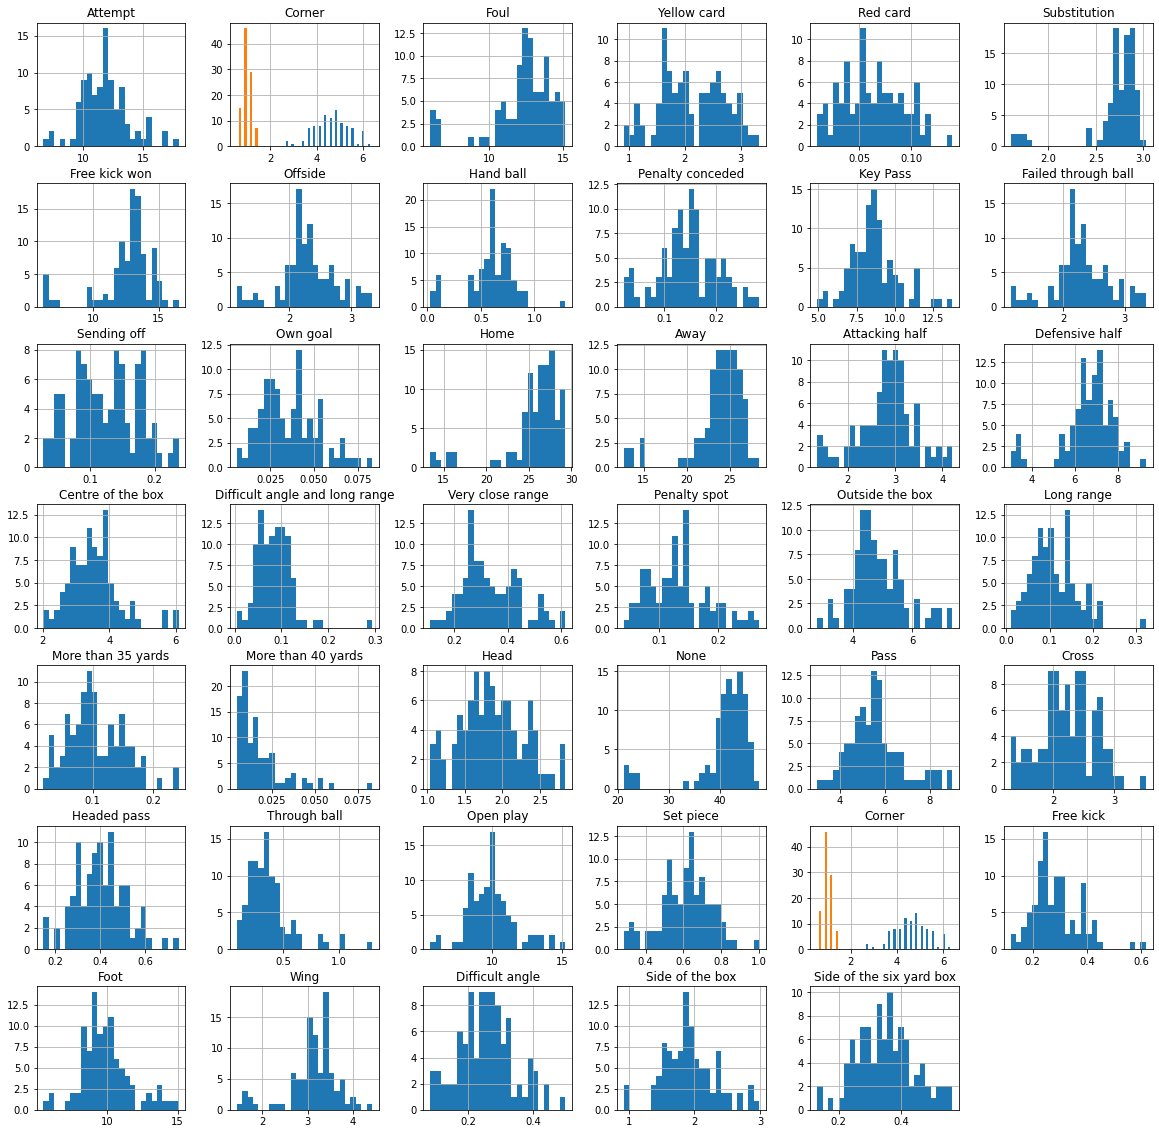

In [34]:
data.hist(figsize=(20,20), bins=25);

***II. Correlation Plot - HeatMap between Features***

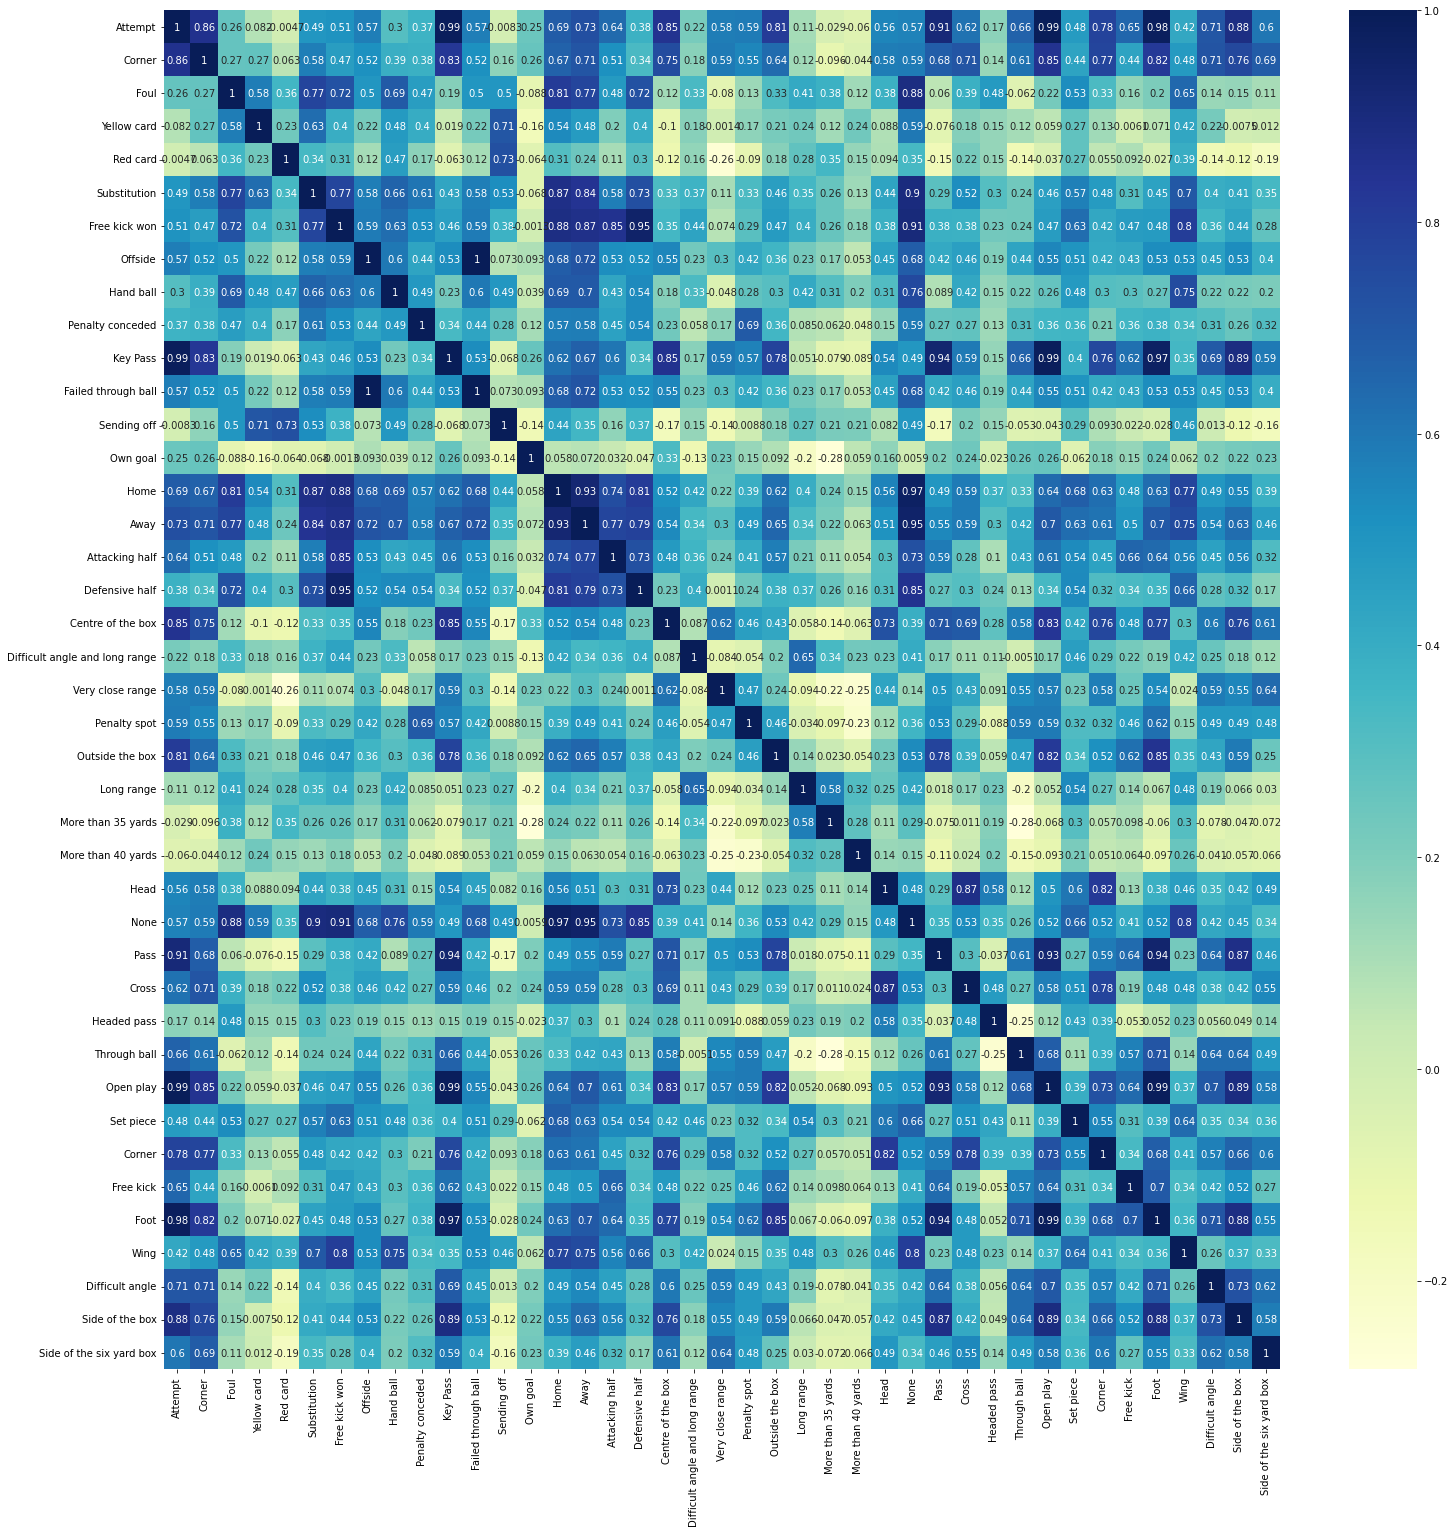

In [35]:
correlation = data.corr()
plt.figure(figsize=(25,25))
sns.heatmap(correlation, cmap="YlGnBu", annot = True)
plt.show()


# **Preparing data for Modelling.**

In [36]:
features = data.copy()

#label = data['Event team']

In [37]:
no_of_col = len(features.columns)

***Scaling and translating each feature individually  in the given range of 0 to 1 on the training set.***

In [38]:
scalar = MinMaxScaler()
features_s = scalar.fit_transform(features)

***Run PCA on the data and reduce the dimensions in pca_num_components dimensions***

In [39]:
pca = PCA()
pca = pca.fit(features_s)

In [40]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([4.26924327e-01, 1.66452471e-01, 6.79871333e-02, 4.89817346e-02,
       4.10344141e-02, 3.20293780e-02, 2.81166488e-02, 2.61423447e-02,
       2.24299516e-02, 1.92531959e-02, 1.57182250e-02, 1.32068948e-02,
       1.22005421e-02, 1.04216514e-02, 9.17594665e-03, 8.31648368e-03,
       6.81111015e-03, 5.88065829e-03, 5.35344121e-03, 5.22423650e-03,
       3.97815365e-03, 3.76197307e-03, 3.70400450e-03, 3.46077010e-03,
       2.83958184e-03, 2.23610679e-03, 1.81646589e-03, 1.72052039e-03,
       1.57444280e-03, 1.14747422e-03, 9.63606986e-04, 7.46007182e-04,
       3.85594315e-04, 3.37836602e-06, 1.07779057e-06, 3.70744214e-08,
       1.46799272e-08, 1.30817652e-09, 2.11683949e-32, 3.36992500e-33,
       3.36992500e-33])

In [41]:
pca_df = pd.DataFrame({'variance':pca.explained_variance_ratio_[0:10],
             'Principal Component':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']})

In [42]:
px.bar(data_frame= pca_df, y = 'variance', x = 'Principal Component',template='plotly_dark' ,color='Principal Component',
       color_continuous_scale='Viridis',
       width=1000,height=500)

In [43]:
def Implement_PCA(n,df):
  pca = PCA(n_components=n)
  pca_data = pca.fit_transform(df)
  return pca_data

In [44]:
pca_df_2 = Implement_PCA(2,features_s)


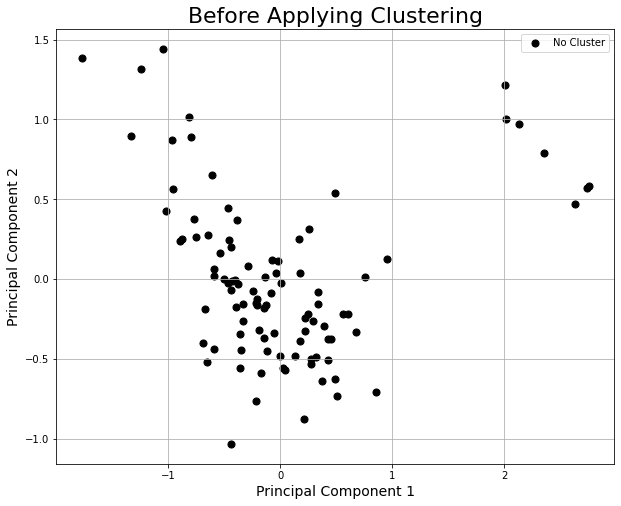

In [45]:
plt.figure(figsize=(10,8))
plt.scatter(
   pca_df_2[:, 0], pca_df_2[:, 1],
   c='black', marker='o',
   edgecolor='black', s=50,
   label='No Cluster'
)
plt.title('Before Applying Clustering', fontsize=22)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

# **Building the K-Means Cluster Model using Scikit - SKlearn library**


KMeans Algorithm to decide the optimum cluster number , KMeans++ using Elbow Mmethod to figure out K for KMeans, I will use ELBOW Method on KMEANS++ Calculation 

In [46]:
wcss=[]

#we always assume the max number of cluster would be 10
#you can judge the number of clusters by doing averaging
###Static code to get max no of clusters

for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=42)
    #kmeans.fit_transform(X_train)
    kmeans.fit_transform(pca_df_2)
    wcss.append(kmeans.inertia_)

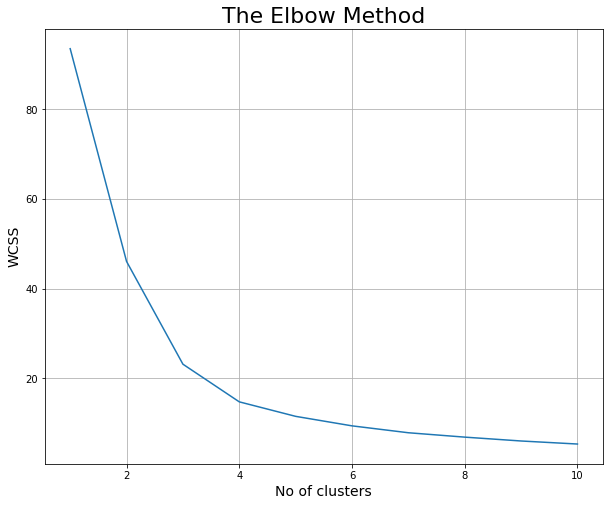

In [47]:
#Visualizing the ELBOW method to get the optimal value of K 
plt.figure(figsize=(10,8))

plt.plot(range(1,11), wcss)

plt.title('The Elbow Method', fontsize=22)
plt.xlabel('No of clusters', fontsize=14)
plt.ylabel('WCSS', fontsize=14)

plt.grid()
plt.show()

From the above scatterplot, you will see that last elbow comes at k=4. No matter what range we select ex- (1,21) also i will see the same behaviour but if we chose higher range it is little difficult to visualize the ELBOW. That is why we usually prefer range (1,11) Finally we got that k=4

In [48]:
k = 4
kmeansmodel = KMeans(n_clusters=k, init='k-means++', random_state=0)


In [49]:
y_predict = kmeansmodel.fit_predict(pca_df_2)

In [50]:
data['cluster']=y_predict
data.head()

,Attempt,Corner,Foul,Yellow card,Red card,Substitution,Free kick won,Offside,Hand ball,Penalty conceded,Key Pass,Failed through ball,Sending off,Own goal,Home,Away,Attacking half,Defensive half,Centre of the box,Difficult angle and long range,Very close range,Penalty spot,Outside the box,Long range,More than 35 yards,More than 40 yards,Head,None,Pass,Cross,Headed pass,Through ball,Open play,Set piece,Corner,Free kick,Foot,Wing,Difficult angle,Side of the box,Side of the six yard box,cluster
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,9.701754,3.938596,13.973684,2.087719,0.105263,2.692982,13.456140,3.201754,0.842105,0.131579,6.684211,3.201754,0.149123,0.035088,27.131579,23.000000,2.500000,7.456140,2.947368,0.078947,0.236842,0.131579,4.008772,0.210526,0.175439,0.026316,1.456140,43.447368,4.298246,1.736842,0.377193,0.271930,8.008772,0.754386,0.649123,0.289474,8.245614,3.500000,0.166667,1.429825,0.219298,3
AC Milan,14.595238,5.833333,12.747619,2.376190,0.085714,2.823810,13.523810,2.585714,0.609524,0.200000,10.476190,2.585714,0.185714,0.052381,28.852381,26.542857,3.204762,7.066667,3.733333,0.047619,0.442857,0.242857,6.976190,0.109524,0.090476,0.004762,1.623810,44.919048,7.409524,2.271429,0.290476,0.504762,12.452381,0.685714,1.042857,0.414286,12.971429,3.252381,0.300000,2.242857,0.300000,2
AS Monaco,12.333333,5.385185,12.340741,1.800000,0.059259,2.851852,12.859259,2.111111,0.785185,0.214815,9.029630,2.111111,0.081481,0.051852,26.192593,24.548148,3.014815,6.281481,4.133333,0.059259,0.414815,0.192593,4.496296,0.081481,0.066667,0.014815,2.177778,41.711111,5.585185,2.688889,0.362963,0.392593,10.274074,0.637037,1.051852,0.370370,10.155556,3.562963,0.259259,1.918519,0.562963,0
AS Nancy Lorraine,11.020833,3.708333,13.125000,1.666667,0.072917,2.416667,12.229167,2.645833,0.697917,0.125000,8.239583,2.645833,0.083333,0.010417,24.270833,23.437500,2.489583,6.437500,2.718750,0.072917,0.291667,0.104167,5.229167,0.177083,0.166667,0.020833,1.750000,39.468750,5.447917,2.010417,0.437500,0.343750,9.104167,0.718750,0.895833,0.302083,9.270833,3.302083,0.156250,1.739583,0.302083,3
AS Roma,15.509524,6.019048,11.914286,2.304762,0.080952,2.833333,13.100000,2.176190,0.547619,0.190476,11.642857,2.176190,0.138095,0.028571,28.619048,26.057143,3.161905,7.104762,4.190476,0.128571,0.428571,0.185714,6.757143,0.123810,0.095238,0.014286,1.776190,43.033333,8.161905,2.257143,0.404762,0.819048,13.261905,0.633333,1.223810,0.390476,13.733333,2.833333,0.371429,2.695238,0.409524,2


In [51]:
print(kmeansmodel.cluster_centers_)

[[-0.31929561 -0.16694283]
 [ 2.37576501  0.80096958]
 [-0.93252559  0.70741252]
 [ 0.36563969 -0.30980589]]


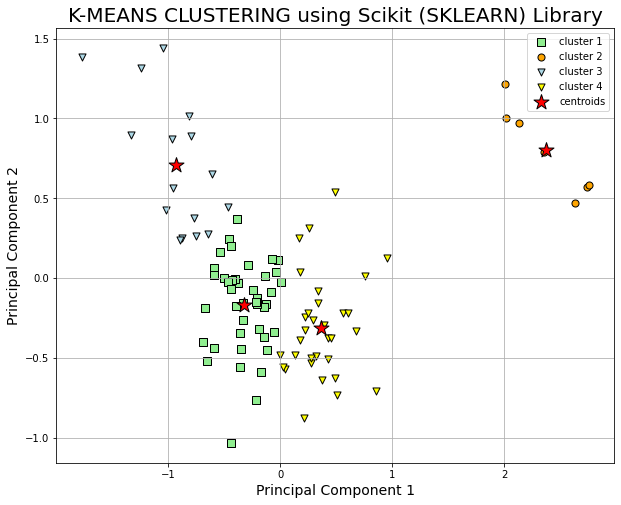

In [52]:
plt.figure(figsize=(10,8))

plt.scatter(
    pca_df_2[y_predict == 0, 0], pca_df_2[y_predict == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    pca_df_2[y_predict == 1, 0], pca_df_2[y_predict == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    pca_df_2[y_predict == 2, 0], pca_df_2[y_predict == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    pca_df_2[y_predict == 3, 0], pca_df_2[y_predict == 3, 1],
    s=50, c='yellow',
    marker='v', edgecolor='black',
    label='cluster 4'
)

# plot the centroids
plt.scatter(
    kmeansmodel.cluster_centers_[:, 0], kmeansmodel.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

plt.title('K-MEANS CLUSTERING using Scikit (SKLEARN) Library', fontsize=20)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()


# **Building the K-Means Cluster Model using Pytorch library**

In [53]:
!pip install tensorflow-gpu==1.15.3 

In [54]:
!pip install torch

In [55]:
!pip install kmeans-pytorch

In [56]:
import torch

from kmeans_pytorch import kmeans, kmeans_predict

In [57]:
# set random seed
np.random.seed(123)

***Use Principal Components for cluster modelling in pytorch***

In [58]:
X = pca_df_2
X = torch.from_numpy(X)

***Set device***

In [59]:

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

***Run the Kmeans technique***

In [60]:
cluster_ids_predict, cluster_centers = kmeans(
    X=X, num_clusters=k, distance='euclidean', device=device
)

running k-means on cuda:0..


[running kmeans]: 10it [00:00, 217.81it/s, center_shift=0.000000, iteration=10, tol=0.000100]


In [61]:
# cluster IDs and cluster centers
print(cluster_ids_predict)
print(cluster_centers)

tensor([1, 3, 3, 1, 2, 1, 3, 3, 3, 2, 1, 3, 2, 1, 3, 2, 1, 1, 3, 3, 3, 1, 0, 3,
        1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 2, 1, 3, 1, 1, 1, 1, 3, 1, 1, 2, 2, 1,
        1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 1, 2, 1, 1, 3, 2, 3, 3, 3, 2, 3,
        3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 0, 0, 3, 3, 0, 1, 1, 3, 3, 3, 3, 1, 3,
        0])
tensor([[ 2.3758,  0.8010],
        [ 0.3094, -0.3347],
        [-1.0531,  0.9460],
        [-0.3918, -0.0686]])


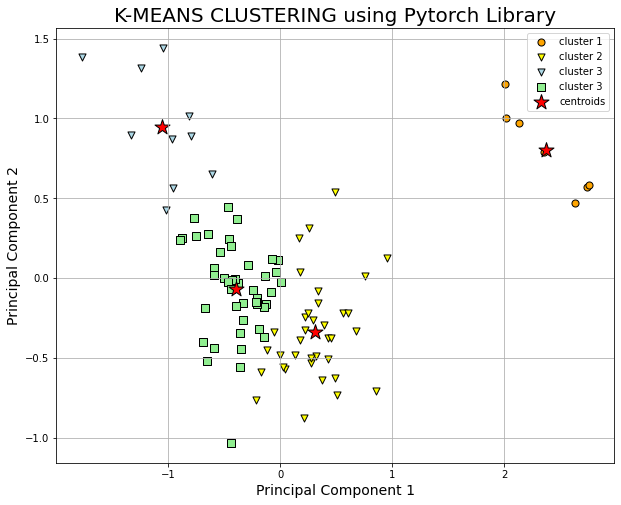

In [62]:
plt.figure(figsize=(10,8))

plt.scatter(
    pca_df_2[cluster_ids_predict == 0, 0], pca_df_2[cluster_ids_predict == 0, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    pca_df_2[cluster_ids_predict == 1, 0], pca_df_2[cluster_ids_predict == 1, 1],
    s=50, c='yellow',
    marker='v', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    pca_df_2[cluster_ids_predict == 2, 0], pca_df_2[cluster_ids_predict == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    pca_df_2[cluster_ids_predict == 3, 0], pca_df_2[cluster_ids_predict == 3, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

plt.title('K-MEANS CLUSTERING using Pytorch Library', fontsize=20)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()